In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [2]:
XL=pd.read_csv('9_510_L_resample_95_5.csv')
XU_train=pd.read_csv('9_510_U_resample_95_5.csv')# No resampling done in the unlabeled set, It just denotes the pair of L and U


In [4]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import load_model
import keras
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder

In [5]:
yL_train=XL.iloc[:,-1]
XL_train=XL.iloc[:,:-1]

In [6]:
yL_train=pd.get_dummies(yL_train)#One-hot_encoding

# Split into train,test and val

#randomly split into train(80%) and val(20%)
XL_train,XL_val,yL_train,yL_val=train_test_split(XL_train,yL_train,random_state=0,test_size=0.2)

#randomly split val into val(10%) and test(10%)
XL_val,XL_test,yL_val,yL_test=train_test_split(XL_val,yL_val,random_state=0,test_size=0.5)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

#scaling and normalization
scaler=StandardScaler()
XU_train=scaler.fit_transform(XU_train)
XL_train=scaler.fit_transform(XL_train)
XL_val=scaler.transform(XL_val)
XL_test=scaler.transform(XL_test)


In [8]:
from keras_sequential_ascii import keras2ascii
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras import backend as K

In [9]:
'''
Function AE
Inputs: numpy array X, list layers,list activations,float rho,int n_epochs,string denoise,float fraction_delete

denoise is the mode of adding noise
rho is the sparcity constraint parameter
layers is a list of no. of hidden nodes in each hidden layer
activations is a list of activations used in each encoding layer

trains each autoencoder layer and outputs all the encoder-layer models.

Output: a list of keras models

'''
def AE(X,layers,activations,n_epochs):
    layers.insert(0,len(X[0]))
    
    ec=[]
    for i in range(len(layers)-1):
        encoding_dim = layers[i+1]

        # this is our input placeholder
        input_ = Input(shape=(layers[i],))

        # "encoded" is the encoded representation of the input
        encoded = Dense(encoding_dim, activation=activations[i],bias_initializer='random_normal',kernel_initializer='he_uniform',name='encoder'+str(i+1))(input_)
        
        # "decoded" is the lossy reconstruction of the input
        decoded = Dense(layers[i],activation=None,name='decoder'+str(i+1))(encoded)

        # this model maps an input to its reconstruction
        autoencoder = Model(input_, decoded)

        # this model maps an input to its encoded representation
        encoder = Model(input_, encoded)

        # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(encoding_dim,))

        autoencoder.compile(optimizer=RMSprop(learning_rate=0.001,clipnorm=0.1), loss='mse')
        
        print('Training Layer ' + str(i+1)+' : ')
        
        autoencoder.fit(X,X,
                epochs=n_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(X,X))
        ec.append(encoder)
        X=encoder.predict(X)
    print('All Layers Done!')    
    return ec       

In [11]:
#Train Sparse Stacked Denoising Autoencoder
layers = [100,200,400,50]
activations=['relu','relu','relu','relu']
traint0=time.time()
stacked_layers=AE(XU_train,layers,activations,10)

Training Layer 1 : 
Train on 384366 samples, validate on 384366 samples
Epoch 1/10
384366/384366 [==============================] - 7s 17us/step - loss: 0.0736 - val_loss: 0.0106
Epoch 2/10
384366/384366 [==============================] - 5s 13us/step - loss: 0.0068 - val_loss: 0.0041
Epoch 3/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0041 - val_loss: 0.0025
Epoch 4/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0034 - val_loss: 0.0063
Epoch 5/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 6/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 7/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/10
384366/384366 [==============================] - 5s 14us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 9/10
384366/384366 [==============================] - 5s 14us/step

In [16]:
model=Sequential()
for i in stacked_layers:
    model.add(i)
    
model.add(Dense(len(yL_train.columns),activation='softmax'))

In [18]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
#fine tune model runs for no. of epochs set below
history=model.fit(XL_train,yL_train,
                epochs=750,
                batch_size=256,
                shuffle=True,
                validation_data=(XL_val, yL_val))
traint1=time.time()

Train on 96292 samples, validate on 12036 samples
Epoch 1/750
96292/96292 [==============================] - 2s 23us/step - loss: 2.7256 - accuracy: 0.2330 - val_loss: 2.2829 - val_accuracy: 0.3328
Epoch 2/750
96292/96292 [==============================] - 2s 22us/step - loss: 2.0508 - accuracy: 0.4130 - val_loss: 1.8988 - val_accuracy: 0.4511
Epoch 3/750
96292/96292 [==============================] - 2s 22us/step - loss: 1.7900 - accuracy: 0.4815 - val_loss: 1.7192 - val_accuracy: 0.5013
Epoch 4/750
96292/96292 [==============================] - 2s 23us/step - loss: 1.6408 - accuracy: 0.5175 - val_loss: 1.6055 - val_accuracy: 0.5303
Epoch 5/750
96292/96292 [==============================] - 2s 21us/step - loss: 1.5300 - accuracy: 0.5470 - val_loss: 1.5141 - val_accuracy: 0.5407
Epoch 6/750
96292/96292 [==============================] - 2s 22us/step - loss: 1.4386 - accuracy: 0.5718 - val_loss: 1.4242 - val_accuracy: 0.5818
Epoch 7/750
96292/96292 [==============================] - 2s 

Epoch 56/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.4908 - accuracy: 0.8432 - val_loss: 0.5480 - val_accuracy: 0.8238
Epoch 57/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.4861 - accuracy: 0.8449 - val_loss: 0.5704 - val_accuracy: 0.8121
Epoch 58/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.4810 - accuracy: 0.8477 - val_loss: 0.5569 - val_accuracy: 0.8211
Epoch 59/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.4761 - accuracy: 0.8478 - val_loss: 0.5532 - val_accuracy: 0.8280
Epoch 60/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.4715 - accuracy: 0.8500 - val_loss: 0.5646 - val_accuracy: 0.8128
Epoch 61/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.4669 - accuracy: 0.8506 - val_loss: 0.5165 - val_accuracy: 0.8324
Epoch 62/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.4622 - accuracy: 0.8526

Epoch 111/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.3280 - accuracy: 0.8935 - val_loss: 0.4202 - val_accuracy: 0.8717
Epoch 112/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.3252 - accuracy: 0.8941 - val_loss: 0.4336 - val_accuracy: 0.8565
Epoch 113/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.3245 - accuracy: 0.8945 - val_loss: 0.4037 - val_accuracy: 0.8726
Epoch 114/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.3220 - accuracy: 0.8954 - val_loss: 0.4158 - val_accuracy: 0.8659
Epoch 115/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.3214 - accuracy: 0.8953 - val_loss: 0.3974 - val_accuracy: 0.8714
Epoch 116/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.3199 - accuracy: 0.8960 - val_loss: 0.4123 - val_accuracy: 0.8681
Epoch 117/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.3174 - accuracy:

96292/96292 [==============================] - 2s 24us/step - loss: 0.2597 - accuracy: 0.9143 - val_loss: 0.3794 - val_accuracy: 0.8778
Epoch 166/750
96292/96292 [==============================] - 2s 25us/step - loss: 0.2592 - accuracy: 0.9154 - val_loss: 0.3771 - val_accuracy: 0.8843
Epoch 167/750
96292/96292 [==============================] - 2s 25us/step - loss: 0.2578 - accuracy: 0.9151 - val_loss: 0.3524 - val_accuracy: 0.8838
Epoch 168/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2569 - accuracy: 0.9158 - val_loss: 0.3471 - val_accuracy: 0.8854
Epoch 169/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2554 - accuracy: 0.9158 - val_loss: 0.3986 - val_accuracy: 0.8734
Epoch 170/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2552 - accuracy: 0.9162 - val_loss: 0.3567 - val_accuracy: 0.8870
Epoch 171/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2542 - accuracy: 0.9165 - val_

Epoch 220/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2187 - accuracy: 0.9265 - val_loss: 0.3390 - val_accuracy: 0.8991
Epoch 221/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2176 - accuracy: 0.9276 - val_loss: 0.3346 - val_accuracy: 0.8877
Epoch 222/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2167 - accuracy: 0.9276 - val_loss: 0.3644 - val_accuracy: 0.8927
Epoch 223/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2167 - accuracy: 0.9274 - val_loss: 0.3295 - val_accuracy: 0.8963
Epoch 224/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2162 - accuracy: 0.9291 - val_loss: 0.4093 - val_accuracy: 0.8711
Epoch 225/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2154 - accuracy: 0.9283 - val_loss: 0.3271 - val_accuracy: 0.9004
Epoch 226/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.2148 - accuracy:

96292/96292 [==============================] - 2s 21us/step - loss: 0.1906 - accuracy: 0.9361 - val_loss: 0.3246 - val_accuracy: 0.9058
Epoch 275/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1904 - accuracy: 0.9362 - val_loss: 0.3629 - val_accuracy: 0.8946
Epoch 276/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1891 - accuracy: 0.9375 - val_loss: 0.3395 - val_accuracy: 0.9003
Epoch 277/750
96292/96292 [==============================] - 2s 23us/step - loss: 0.1896 - accuracy: 0.9373 - val_loss: 0.3273 - val_accuracy: 0.9060
Epoch 278/750
96292/96292 [==============================] - 2s 23us/step - loss: 0.1885 - accuracy: 0.9370 - val_loss: 0.3318 - val_accuracy: 0.9023
Epoch 279/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1885 - accuracy: 0.9373 - val_loss: 0.3196 - val_accuracy: 0.9083
Epoch 280/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1898 - accuracy: 0.9374 - val_

Epoch 329/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1699 - accuracy: 0.9428 - val_loss: 0.3742 - val_accuracy: 0.8925
Epoch 330/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1701 - accuracy: 0.9433 - val_loss: 0.3432 - val_accuracy: 0.9048
Epoch 331/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1702 - accuracy: 0.9430 - val_loss: 0.3319 - val_accuracy: 0.9011
Epoch 332/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1697 - accuracy: 0.9424 - val_loss: 0.3225 - val_accuracy: 0.9098
Epoch 333/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1696 - accuracy: 0.9437 - val_loss: 0.3816 - val_accuracy: 0.8936
Epoch 334/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1688 - accuracy: 0.9433 - val_loss: 0.3052 - val_accuracy: 0.9158
Epoch 335/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1687 - accuracy:

96292/96292 [==============================] - 2s 21us/step - loss: 0.1544 - accuracy: 0.9479 - val_loss: 0.3483 - val_accuracy: 0.8949
Epoch 384/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1546 - accuracy: 0.9481 - val_loss: 0.3169 - val_accuracy: 0.9135
Epoch 385/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1537 - accuracy: 0.9483 - val_loss: 0.3584 - val_accuracy: 0.9056
Epoch 386/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1552 - accuracy: 0.9475 - val_loss: 0.3358 - val_accuracy: 0.9078
Epoch 387/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1551 - accuracy: 0.9488 - val_loss: 0.3196 - val_accuracy: 0.9197
Epoch 388/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1522 - accuracy: 0.9488 - val_loss: 0.3718 - val_accuracy: 0.9056
Epoch 389/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1528 - accuracy: 0.9487 - val_

96292/96292 [==============================] - 2s 21us/step - loss: 0.1420 - accuracy: 0.9520 - val_loss: 0.3260 - val_accuracy: 0.9152
Epoch 438/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1415 - accuracy: 0.9519 - val_loss: 0.3418 - val_accuracy: 0.9162
Epoch 439/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1426 - accuracy: 0.9519 - val_loss: 0.4034 - val_accuracy: 0.8927
Epoch 440/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1412 - accuracy: 0.9528 - val_loss: 0.3716 - val_accuracy: 0.8935
Epoch 441/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1415 - accuracy: 0.9527 - val_loss: 0.3331 - val_accuracy: 0.9120
Epoch 442/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1412 - accuracy: 0.9525 - val_loss: 0.3667 - val_accuracy: 0.9017
Epoch 443/750
96292/96292 [==============================] - 2s 22us/step - loss: 0.1414 - accuracy: 0.9518 - val_

Epoch 492/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1323 - accuracy: 0.9552 - val_loss: 0.3631 - val_accuracy: 0.9101
Epoch 493/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1327 - accuracy: 0.9551 - val_loss: 0.3724 - val_accuracy: 0.9141
Epoch 494/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1321 - accuracy: 0.9555 - val_loss: 0.4697 - val_accuracy: 0.8902
Epoch 495/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1319 - accuracy: 0.9555 - val_loss: 0.3671 - val_accuracy: 0.9088
Epoch 496/750
96292/96292 [==============================] - 2s 22us/step - loss: 0.1316 - accuracy: 0.9553 - val_loss: 0.3472 - val_accuracy: 0.9169
Epoch 497/750
96292/96292 [==============================] - 2s 22us/step - loss: 0.1305 - accuracy: 0.9556 - val_loss: 0.4083 - val_accuracy: 0.9078
Epoch 498/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1311 - accuracy:

96292/96292 [==============================] - 2s 21us/step - loss: 0.1243 - accuracy: 0.9578 - val_loss: 0.3508 - val_accuracy: 0.9224
Epoch 547/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1234 - accuracy: 0.9581 - val_loss: 0.3821 - val_accuracy: 0.9118
Epoch 548/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1247 - accuracy: 0.9577 - val_loss: 0.4226 - val_accuracy: 0.9069
Epoch 549/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1233 - accuracy: 0.9580 - val_loss: 0.3455 - val_accuracy: 0.9243
Epoch 550/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1231 - accuracy: 0.9580 - val_loss: 0.3696 - val_accuracy: 0.9148
Epoch 551/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1232 - accuracy: 0.9580 - val_loss: 0.3618 - val_accuracy: 0.9050
Epoch 552/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1242 - accuracy: 0.9580 - val_

Epoch 601/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1177 - accuracy: 0.9600 - val_loss: 0.4251 - val_accuracy: 0.9126
Epoch 602/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1174 - accuracy: 0.9603 - val_loss: 0.3359 - val_accuracy: 0.9261
Epoch 603/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1161 - accuracy: 0.9607 - val_loss: 0.3580 - val_accuracy: 0.9167
Epoch 604/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1168 - accuracy: 0.9609 - val_loss: 0.3566 - val_accuracy: 0.9222
Epoch 605/750
96292/96292 [==============================] - 2s 24us/step - loss: 0.1169 - accuracy: 0.9599 - val_loss: 0.3462 - val_accuracy: 0.9261
Epoch 606/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1164 - accuracy: 0.9597 - val_loss: 0.3460 - val_accuracy: 0.9270
Epoch 607/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1168 - accuracy:

96292/96292 [==============================] - 2s 21us/step - loss: 0.1107 - accuracy: 0.9624 - val_loss: 0.5352 - val_accuracy: 0.8726
Epoch 656/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1117 - accuracy: 0.9620 - val_loss: 0.4804 - val_accuracy: 0.8932
Epoch 657/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1114 - accuracy: 0.9615 - val_loss: 0.3646 - val_accuracy: 0.9286
Epoch 658/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1116 - accuracy: 0.9621 - val_loss: 0.3878 - val_accuracy: 0.9089
Epoch 659/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1107 - accuracy: 0.9620 - val_loss: 0.3438 - val_accuracy: 0.9272
Epoch 660/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1103 - accuracy: 0.9621 - val_loss: 0.3451 - val_accuracy: 0.9279
Epoch 661/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1103 - accuracy: 0.9626 - val_

Epoch 710/750
96292/96292 [==============================] - 2s 22us/step - loss: 0.1073 - accuracy: 0.9629 - val_loss: 0.3567 - val_accuracy: 0.9301
Epoch 711/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1068 - accuracy: 0.9634 - val_loss: 0.3961 - val_accuracy: 0.9221
Epoch 712/750
96292/96292 [==============================] - 2s 22us/step - loss: 0.1078 - accuracy: 0.9630 - val_loss: 0.3564 - val_accuracy: 0.9336
Epoch 713/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1058 - accuracy: 0.9637 - val_loss: 0.4008 - val_accuracy: 0.9204
Epoch 714/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1073 - accuracy: 0.9635 - val_loss: 0.3853 - val_accuracy: 0.9256
Epoch 715/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1065 - accuracy: 0.9634 - val_loss: 0.3791 - val_accuracy: 0.9111
Epoch 716/750
96292/96292 [==============================] - 2s 21us/step - loss: 0.1062 - accuracy:

In [34]:
print("Train_time: "+str(traint1-traint0))

Train_time: 1944.3309953212738


In [21]:
test0=time.time()
print(model.evaluate(XL_test,yL_test))
test1=time.time()
print("Test_time: "+str(test1-test0))

12037/12037 [==============================] - 0s 29us/step
[0.3455311880385305, 0.9258951544761658]
Test_time: 0.34892797470092773


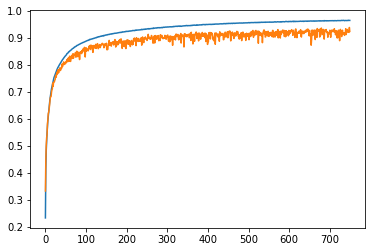

In [22]:
#Visualise convergence with no. of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [24]:
y_pred=model.predict(XL_test)
y_pred1=y_pred.argmax(axis=1)
y_pred1=np.append(y_pred1,np.arange(24))
y_pred1=pd.get_dummies(y_pred1,columns=yL_train.columns)
y_pred1.columns=yL_test.columns
y_pred1=y_pred1.iloc[:-24]

In [25]:
yL_test.sum()

AMAZON            500
APPLE             474
APPLE_ITUNES      515
CLOUDFLARE        461
CONTENT_FLASH     494
DROPBOX           487
EBAY              508
FACEBOOK          473
GMAIL             501
GOOGLE            550
HTTP              491
HTTP_CONNECT      490
HTTP_PROXY        533
MICROSOFT         497
MSN               497
OFFICE_365        522
SKYPE             491
SSL               517
TWITTER           509
WHATSAPP          506
WIKIPEDIA         511
WINDOWS_UPDATE    502
YAHOO             515
YOUTUBE           493
dtype: int64

In [26]:
y_test1 = yL_test.columns[np.where(yL_test!=0)[1]]

In [27]:
y_pred1=y_pred1.columns[np.where(y_pred1!=0)[1]]
cm=confusion_matrix(y_test1,y_pred1,labels=yL_test.columns)
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=yL_test.columns,index=yL_test.columns)
cm_pc=cm_pc.replace(np.nan,0)

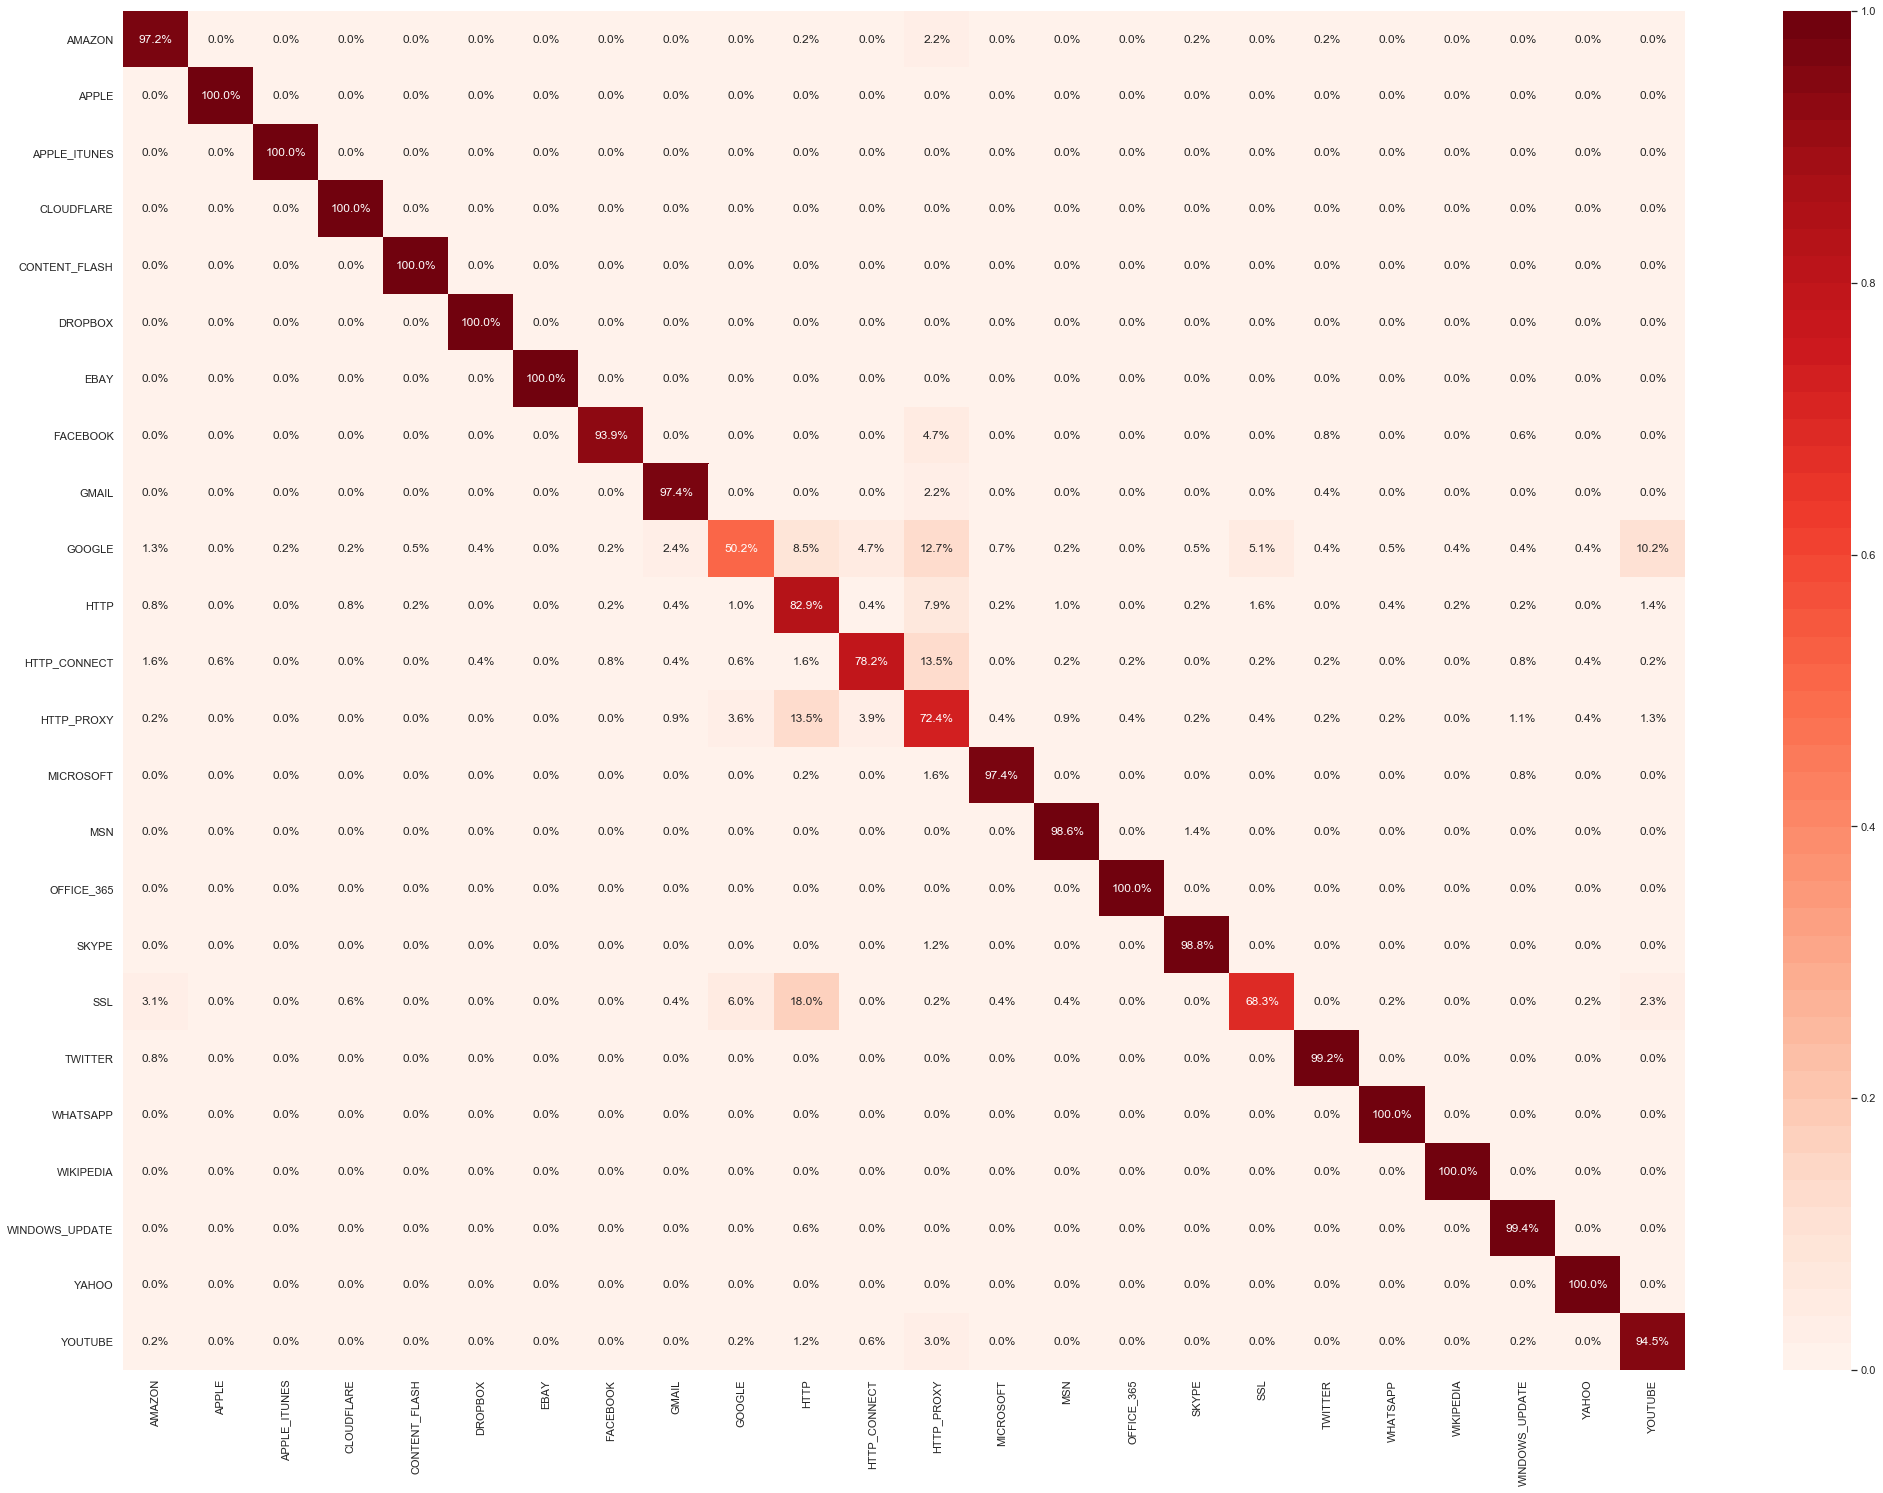

In [28]:
# Plot confusion matrix
plt.figure(figsize=(35,25))
df_cm=pd.DataFrame(cm,columns=yL_test.columns,index=yL_test.columns)
sns.set(font_scale=1.0)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",50)) # font size
plt.show()

In [29]:
print('Test Accuracy : '+str(accuracy_score(y_test1, y_pred1)))

Test Accuracy : 0.9258951566004818


In [30]:
print('weighted F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'weighted')))
print('Macro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'macro')))
print('Micro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'micro')))
print('F1 Scores : ' )
pd.DataFrame(f1_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['F1-score'],index=yL_test.columns)

weighted F1 Score : 0.9273424425245091
Macro F1 Score : 0.9265045586908415
Micro F1 Score : 0.9258951566004818
F1 Scores : 


,F1-score
AMAZON,0.946446
APPLE,0.996845
APPLE_ITUNES,0.999030
CLOUDFLARE,0.991398
CONTENT_FLASH,0.995968
DROPBOX,0.995910
EBAY,1.000000
FACEBOOK,0.962080
GMAIL,0.963475
GOOGLE,0.623729


In [31]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [32]:
print('Macro Presicion : '+str(precision_score(y_test1, y_pred1,average="macro")))
print('Micro Presicion : '+str(precision_score(y_test1, y_pred1,average="micro")))
print('Weighted Presicion : '+str(precision_score(y_test1, y_pred1,average="weighted")))
print('Precision Scores : ' )
pd.DataFrame(precision_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['Precision-score'],index=yL_test.columns)

Macro Presicion : 0.9311481066645017
Micro Presicion : 0.9258951566004818
Weighted Presicion : 0.9299448808565974
Precision Scores : 


,Precision-score
AMAZON,0.972000
APPLE,1.000000
APPLE_ITUNES,1.000000
CLOUDFLARE,1.000000
CONTENT_FLASH,1.000000
DROPBOX,1.000000
EBAY,1.000000
FACEBOOK,0.938689
GMAIL,0.974052
GOOGLE,0.501818


In [33]:
print('Macro Recall : '+str(recall_score(y_test1, y_pred1,average="macro")))
print('Micro Recall : '+str(recall_score(y_test1, y_pred1,average="micro")))
print('Weighted Recall : '+str(recall_score(y_test1, y_pred1,average="weighted")))
print('Recall Scores : ' )
pd.DataFrame(recall_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['recall-score'],index=yL_test.columns)

Macro Recall : 0.9284599025639003
Micro Recall : 0.9258951566004818
Weighted Recall : 0.9258951566004818
Recall Scores : 


,recall-score
AMAZON,0.922201
APPLE,0.993711
APPLE_ITUNES,0.998062
CLOUDFLARE,0.982942
CONTENT_FLASH,0.991968
DROPBOX,0.991853
EBAY,1.000000
FACEBOOK,0.986667
GMAIL,0.953125
GOOGLE,0.823881
